In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering,DBSCAN
from scipy.cluster import hierarchy
from sklearn.metrics import silhouette_score
import matplotlib.patheffects as PathEffects
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
import time

In [ ]:
file_path = '/content/drive/MyDrive/Merged Data/LatestData/X_scaled_3.csv'
X_sc = pd.read_csv(file_path)

In [ ]:
X_sc.columns

Index(['Category_Equity', 'Category_Debt', 'Category_Hybrid', 'Expense_ratio',
       'Risk_factor', 'age_in_months', 'Rating', 'Net_assets', 'Return_1wk',
       'Return_1m', 'Return_3m', 'Return_6m', 'Return_1yr', 'Return_3yr',
       'Return_5yr', 'Return_10yr', 'Equity_fund_style_Growth',
       'Equity_fund_style_Value', 'Equity_fund_style_Blend',
       'Standard Deviation', 'Sharpe Ratio', 'Sortino Ratio', 'NAV_latest',
       'NAV_52wk_high', 'NAV_52wk_low', 'Minimum_Investment',
       'Fund_Manager_Tenure', '#_Funds_managed'],
      dtype='object')

In [ ]:
features = X_sc.columns.values 
## Creating Dictionary for Hyper Parameters grid search in each model
## Creating Dictionary for Hyper Parameters grid search in each model
model_dic = {"kmeans": {"init_seed": [10],
                  "inits"  :  ["k-means++","random"],
                  "clusters_list": range(2,20),
                  "tol": 0.0001},
             
            "hierarchy": {"linkage_method":['complete','ward', 'single','centroid','median','weighted'],
                          "t": range(4,15),
                          "criterion": "maxclust"},
             
           "Agglomerative": {"linkage_method":['complete','ward', 'single',
                             'centroid','median','weighted'],'clusters_list':range(4,15),
                             "affinity": ['euclidean', 'l1', 'l2', 'manhattan',
                             'cosine', 'precomputed'],"clusters_list": range(4,10)},
             
            "dbscan": {"epslons":np.linspace(0.5,20,20),
                       "min_samples": [1,3,5,7,9,11,13,15,17,19,21,23,25,27,31]            
            }}

## Dictonary with features lists to grid search
df_dic = {'features': X_sc[features]}

In [ ]:
def grid_clusters(df_dic, par_dic):
    result_dic = {"Data_frame" :[],
                  "model": [],
                  "inertia": [],
                  "silhouette": [],
                  "Numb_clusters": [],
                  "Cluster_counts": [],
                  "model_params": []
                  }
    # loop dataFrames
    for df_name, df_data in df_dic.items():
        X = df_data
        # loop models
        for n_model in par_dic.keys():
            if n_model == "kmeans":
                # loop centroid seeds
                for n_init_seed in par_dic['kmeans']['init_seed']:
                    # loop Method for initialization
                    for n_init_method in par_dic['kmeans']['inits']:
                            # loop number of clusters
                            for n_cluster in par_dic['kmeans']['clusters_list']:
                                kmeans = KMeans(n_clusters=n_cluster,
                                                init=n_init_method,
                                                n_init=n_init_seed,
                                                tol=par_dic['kmeans']['tol'],
                                                random_state=42)
                                kmeans.fit(X)
                                #Saving results in dic
                                result_dic['Data_frame'].append(df_name)
                                result_dic['model'].append(n_model)
                                result_dic['inertia'].append(kmeans.inertia_)
                                result_dic['silhouette'].append(silhouette_score(X, kmeans.labels_))
                                result_dic['Numb_clusters'].append(n_cluster)
                                result_dic['Cluster_counts'].append(list(pd.Series(kmeans.labels_).value_counts()))
                                result_dic['model_params'].append("n_init_Seed: "
                                                                  + str(n_init_seed) +
                                                                  " n_init_met: " + 
                                                                  str(n_init_method)) 
                                
            if n_model == "hierarchy":
                # loop linkage_method
                for n_link_met in par_dic['hierarchy']['linkage_method']:
                    for n_clusters in par_dic['hierarchy']['t']:
                        z = hierarchy.linkage(X, method=n_link_met)
                        cls = hierarchy.fcluster(z, n_clusters, "maxclust")
                        # Saving results in dic
                        result_dic['Data_frame'].append(df_name)
                        result_dic['model'].append(n_model)
                        result_dic['inertia'].append(0)
                        result_dic['silhouette'].append(silhouette_score(X, cls))
                        result_dic['Numb_clusters'].append(n_clusters)
                        result_dic['Cluster_counts'].append(list(pd.Series(cls).value_counts()))
                        result_dic['model_params'].append(n_link_met)
                        
            if n_model == "Agglomerative":
                # loop linkage criterion
                for n_link_met in par_dic['Agglomerative']['linkage_method']:
                    #loop number of clusters
                    for n_clusters in par_dic['Agglomerative']['clusters_list']:
                        # loop method to compute linkage
                        for n_affinity in par_dic['Agglomerative']['affinity']:
                            ac = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
                            ac.fit(X)
                            # Saving results in dic
                            result_dic['Data_frame'].append(df_name)
                            result_dic['model'].append(n_model)
                            result_dic['inertia'].append(0)
                            result_dic['silhouette'].append(silhouette_score(X, ac.labels_))
                            result_dic['Numb_clusters'].append(n_clusters)
                            result_dic['Cluster_counts'].append(list(pd.Series(ac.labels_).value_counts()))
                            result_dic['model_params'].append("Afin:" + n_affinity + ", Link:, " + n_link_met)
            
            if n_model == "dbscan":
                for e in par_dic['dbscan']['epslons']:
                    for samp in par_dic['dbscan']['min_samples']:
                        dbsc = DBSCAN(eps = e,
                                      min_samples = samp,
                                      metric='euclidean',
                                      leaf_size=30
                                      ).fit(X)
                        n_clusters = len(list(pd.Series(dbsc.labels_).value_counts()))
                        if n_clusters > 1 :      
                            result_dic['Data_frame'].append(df_name)
                            result_dic['model'].append(n_model)
                            result_dic['inertia'].append(0)
                            result_dic['silhouette'].append(silhouette_score(X, dbsc.labels_))
                            result_dic['Numb_clusters'].append(n_clusters)
                            result_dic['Cluster_counts'].append(list(pd.Series(dbsc.labels_).value_counts()))
                            result_dic['model_params'].append("Epslon:" + str(round(e,2)) + ", min_samp: " + str(samp))                           
    return pd.DataFrame(result_dic)

In [ ]:
## Runing grid search
results = grid_clusters(df_dic,model_dic)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be remo

In [ ]:
# Top agglomerative silhouette score
display(results[(results.model == 'Agglomerative')]\
.sort_values(by=['silhouette'],ascending = False).head(4))

# Top kmeans silhouette score
display(results[(results.model == 'kmeans')]\
.sort_values(by=['silhouette'],ascending = False).head(4))

# Top hierarchy silhouette score
display(results[(results.model == 'hierarchy')]\
.sort_values(by=['silhouette'],ascending = False).head(4))

# Top dbscan silhouette score
display(results[(results.model == 'dbscan') &
               (results.Numb_clusters >= 1)]\
.sort_values(by=['silhouette'],ascending = False).head(4))

,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
317,features,Agglomerative,0.0,0.209734,9,"[231, 222, 156, 144, 71, 62, 28, 11, 1]","Afin:precomputed, Link:, weighted"
132,features,Agglomerative,0.0,0.209734,9,"[231, 222, 156, 144, 71, 62, 28, 11, 1]","Afin:euclidean, Link:, complete"
169,features,Agglomerative,0.0,0.209734,9,"[231, 222, 156, 144, 71, 62, 28, 11, 1]","Afin:l1, Link:, ward"
170,features,Agglomerative,0.0,0.209734,9,"[231, 222, 156, 144, 71, 62, 28, 11, 1]","Afin:l2, Link:, ward"


,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
0,features,kmeans,19947.192682,0.256181,2,"[598, 328]",n_init_Seed: 10 n_init_met: k-means++
18,features,kmeans,19947.192682,0.256181,2,"[598, 328]",n_init_Seed: 10 n_init_met: random
1,features,kmeans,17800.876799,0.243917,3,"[532, 332, 62]",n_init_Seed: 10 n_init_met: k-means++
25,features,kmeans,12270.851653,0.228805,9,"[230, 221, 138, 136, 74, 62, 27, 27, 11]",n_init_Seed: 10 n_init_met: random


,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
69,features,hierarchy,0.0,0.591561,4,"[923, 1, 1, 1]",centroid
80,features,hierarchy,0.0,0.507765,4,"[922, 2, 1, 1]",median
91,features,hierarchy,0.0,0.507765,4,"[922, 2, 1, 1]",weighted
36,features,hierarchy,0.0,0.507765,4,"[922, 2, 1, 1]",complete


,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
596,features,dbscan,0.0,0.743419,2,"[925, 1]","Epslon:20.0, min_samp: 31"
566,features,dbscan,0.0,0.743419,2,"[925, 1]","Epslon:17.95, min_samp: 31"
564,features,dbscan,0.0,0.743419,2,"[925, 1]","Epslon:17.95, min_samp: 25"
563,features,dbscan,0.0,0.743419,2,"[925, 1]","Epslon:17.95, min_samp: 23"


DBSCAN

In [ ]:
display(results[(results.model == 'dbscan') &
               (results.Numb_clusters >= 3 )]\
.sort_values(by=['silhouette'],ascending = False)[56:69])

,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
320,features,dbscan,0.0,0.018095,622,"[83, 40, 25, 23, 16, 10, 7, 6, 6, 6, 5, 5, 5, ...","Epslon:1.53, min_samp: 1"
339,features,dbscan,0.0,0.015537,5,"[457, 221, 154, 68, 26]","Epslon:2.55, min_samp: 25"
342,features,dbscan,0.0,-0.000297,57,"[488, 283, 69, 22, 3, 3, 3, 2, 2, 2, 2, 2, 1, ...","Epslon:3.58, min_samp: 1"
341,features,dbscan,0.0,-0.018929,4,"[569, 152, 150, 55]","Epslon:2.55, min_samp: 31"
327,features,dbscan,0.0,-0.032895,184,"[285, 169, 116, 49, 40, 16, 12, 11, 8, 7, 5, 5...","Epslon:2.55, min_samp: 1"
340,features,dbscan,0.0,-0.036776,6,"[501, 154, 148, 67, 45, 11]","Epslon:2.55, min_samp: 27"
325,features,dbscan,0.0,-0.069315,3,"[870, 39, 17]","Epslon:1.53, min_samp: 11"
326,features,dbscan,0.0,-0.103781,3,"[894, 17, 15]","Epslon:1.53, min_samp: 13"
319,features,dbscan,0.0,-0.201754,4,"[916, 4, 3, 3]","Epslon:0.5, min_samp: 3"
324,features,dbscan,0.0,-0.211623,4,"[857, 43, 17, 9]","Epslon:1.53, min_samp: 9"


In [ ]:
## DBSCAN Parameters Chosen:
display(results.loc[[384]])
# saving parameters in instantiated model 
dbsc_1 = DBSCAN(eps = 4.61, min_samples = 31).fit(X_sc[features]).labels_
# dbsc_2 = DBSCAN(eps = 3.58, min_samples = 5).fit(X_sc).labels_

,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
384,features,dbscan,0.0,0.464248,2,"[903, 23]","Epslon:5.63, min_samp: 25"


Hierarchy

In [ ]:
display(results[(results.model == 'hierarchy') &
               (results.Numb_clusters <10 )]\
.sort_values(by=['silhouette'],ascending = False)[30:80])

,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
49,features,hierarchy,0.0,0.194063,6,"[243, 232, 222, 156, 62, 11]",ward
47,features,hierarchy,0.0,0.192719,4,"[476, 232, 156, 62]",ward
39,features,hierarchy,0.0,0.133177,7,"[866, 33, 13, 10, 2, 1, 1]",complete
41,features,hierarchy,0.0,0.132380,9,"[863, 31, 13, 10, 3, 2, 2, 1, 1]",complete
40,features,hierarchy,0.0,0.131727,8,"[866, 31, 13, 10, 2, 2, 1, 1]",complete
38,features,hierarchy,0.0,0.120869,6,"[876, 33, 13, 2, 1, 1]",complete


In [ ]:
## Hierarchy Parameters:
display(results.loc[[47]])
# saving labels 
z = hierarchy.linkage(X_sc[features], method="ward")
hierarchy_1 = hierarchy.fcluster(z, 4, "maxclust")
print("This model silhouette score: ",silhouette_score(X_sc[features], hierarchy_1))

,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
47,features,hierarchy,0.0,0.192719,4,"[476, 232, 156, 62]",ward


This model silhouette score:  0.192719499175429


Agglomerative

In [ ]:
display(results[(results.model == 'Agglomerative')& (results.Numb_clusters <10)]\
.sort_values(by=['silhouette'],ascending = False)[0:10])

,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
317,features,Agglomerative,0.0,0.209734,9,"[231, 222, 156, 144, 71, 62, 28, 11, 1]","Afin:precomputed, Link:, weighted"
132,features,Agglomerative,0.0,0.209734,9,"[231, 222, 156, 144, 71, 62, 28, 11, 1]","Afin:euclidean, Link:, complete"
169,features,Agglomerative,0.0,0.209734,9,"[231, 222, 156, 144, 71, 62, 28, 11, 1]","Afin:l1, Link:, ward"
170,features,Agglomerative,0.0,0.209734,9,"[231, 222, 156, 144, 71, 62, 28, 11, 1]","Afin:l2, Link:, ward"
171,features,Agglomerative,0.0,0.209734,9,"[231, 222, 156, 144, 71, 62, 28, 11, 1]","Afin:manhattan, Link:, ward"
172,features,Agglomerative,0.0,0.209734,9,"[231, 222, 156, 144, 71, 62, 28, 11, 1]","Afin:cosine, Link:, ward"
173,features,Agglomerative,0.0,0.209734,9,"[231, 222, 156, 144, 71, 62, 28, 11, 1]","Afin:precomputed, Link:, ward"
245,features,Agglomerative,0.0,0.209734,9,"[231, 222, 156, 144, 71, 62, 28, 11, 1]","Afin:precomputed, Link:, centroid"
244,features,Agglomerative,0.0,0.209734,9,"[231, 222, 156, 144, 71, 62, 28, 11, 1]","Afin:cosine, Link:, centroid"
133,features,Agglomerative,0.0,0.209734,9,"[231, 222, 156, 144, 71, 62, 28, 11, 1]","Afin:l1, Link:, complete"


In [ ]:
display(results.loc[[317]])
# Agglomerative parameters
ac = AgglomerativeClustering(n_clusters=9)
ac.fit(X_sc[features])
print("This model silhouette score: ",silhouette_score(X_sc[features],  ac.labels_))
agglomerative_1 = ac.labels_

,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
317,features,Agglomerative,0.0,0.209734,9,"[231, 222, 156, 144, 71, 62, 28, 11, 1]","Afin:precomputed, Link:, weighted"


This model silhouette score:  0.20973365985947784


K-means

In [ ]:
display(results[(results.model == 'kmeans') & (results.Numb_clusters <10) ]\
.sort_values(by=['inertia'],ascending = True).sort_values(by=['silhouette'],ascending = False).\
        head(40))

,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
0,features,kmeans,19947.192682,0.256181,2,"[598, 328]",n_init_Seed: 10 n_init_met: k-means++
18,features,kmeans,19947.192682,0.256181,2,"[598, 328]",n_init_Seed: 10 n_init_met: random
1,features,kmeans,17800.876799,0.243917,3,"[532, 332, 62]",n_init_Seed: 10 n_init_met: k-means++
25,features,kmeans,12270.851653,0.228805,9,"[230, 221, 138, 136, 74, 62, 27, 27, 11]",n_init_Seed: 10 n_init_met: random
6,features,kmeans,12558.009362,0.227914,8,"[265, 231, 167, 161, 62, 29, 10, 1]",n_init_Seed: 10 n_init_met: k-means++
23,features,kmeans,13259.218239,0.225833,7,"[265, 232, 167, 161, 61, 29, 11]",n_init_Seed: 10 n_init_met: random
5,features,kmeans,13267.754683,0.225468,7,"[265, 233, 167, 161, 61, 29, 10]",n_init_Seed: 10 n_init_met: k-means++
24,features,kmeans,12635.380873,0.218947,8,"[231, 224, 158, 135, 78, 62, 27, 11]",n_init_Seed: 10 n_init_met: random
22,features,kmeans,13964.958785,0.217959,6,"[270, 234, 188, 161, 62, 11]",n_init_Seed: 10 n_init_met: random
4,features,kmeans,13973.067146,0.217653,6,"[271, 235, 187, 161, 62, 10]",n_init_Seed: 10 n_init_met: k-means++


In [ ]:
# Kmeans parameters
display(results.loc[[21]])
kmeans_1 = KMeans(n_clusters=5, init='random',random_state=42).fit(X_sc[features])
print("This model silhouette score: ",silhouette_score(X_sc[features],  kmeans_1.labels_))
kmeans_1 = kmeans_1.labels_

,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
21,features,kmeans,15018.238476,0.211902,5,"[275, 234, 194, 161, 62]",n_init_Seed: 10 n_init_met: random


This model silhouette score:  0.21190177828932363


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# Kmeans parameters
display(results.loc[[7]])
kmeans_2 = KMeans(n_clusters=9, init='k-means++',
                random_state=42).fit(X_sc[features])
print("This model silhouette score: ",silhouette_score(X_sc[features],  kmeans_2.labels_))
kmeans_2 = kmeans_2.labels_

,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
7,features,kmeans,12179.296033,0.187473,9,"[223, 152, 126, 122, 119, 86, 59, 29, 10]",n_init_Seed: 10 n_init_met: k-means++


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


This model silhouette score:  0.18747320105371537


In [ ]:
# raw_df.groupby(['dbscan_s9_e_4.5'])[["Return_6m",'Return_12m','Return_24m']].agg([np.median])

In [ ]:
## Checking number of Cluster using the elbow method

Analizing Elbow method with KMeans

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

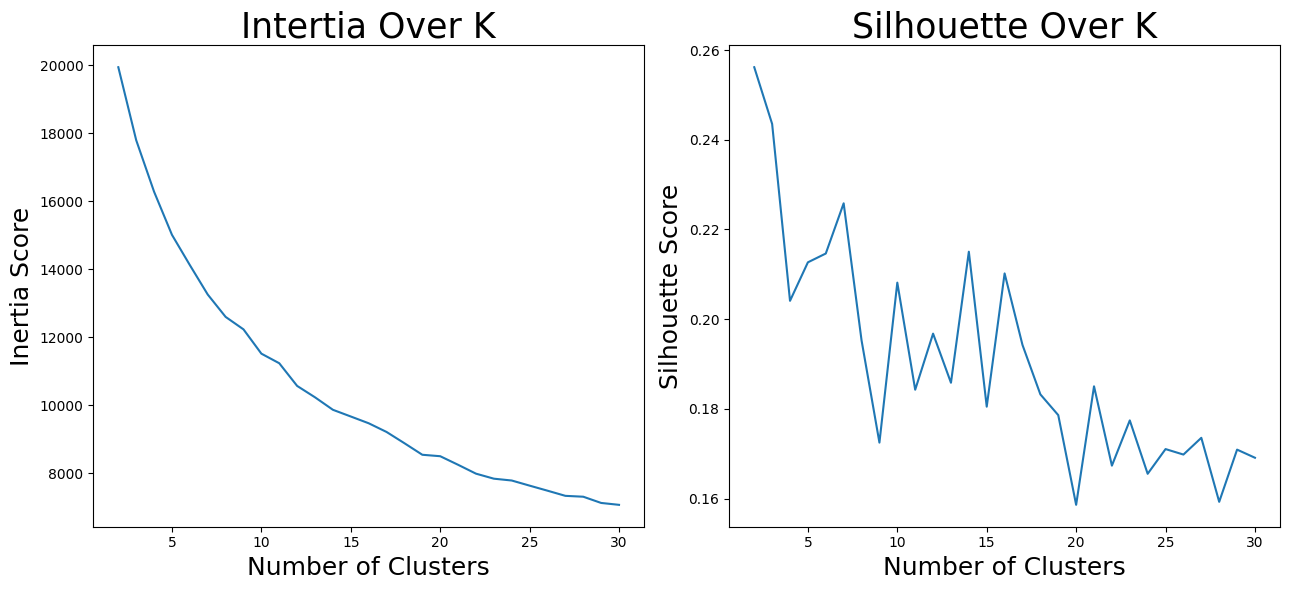

In [ ]:
from sklearn.metrics import silhouette_score 
from sklearn.model_selection import ParameterGrid

class eval_kmeans:
    
    param_grid = dict(n_clusters=np.arange(2, 31))
    model = None
    scores = []
    
    def __init__(self, param_grid = None):
        
        if param_grid:
            self.param_grid = ParameterGrid(param_grid)
    
    def fit(self, X, scorer="silhouette"):
        
        ## This isn't very smart ATM.  Only one param, K, is being searched.
        for param, values in self.param_grid.items():
            
            for value in values:
        
                estimator = KMeans(n_clusters = value,)
                model = estimator.fit(X)
                
                # Populate scores
                score    = silhouette_score(X, model.labels_)
                
                self.scores.append({
                    param:        value,
                    "inertia":    model.inertia_,
                    "silhouette": score
                })
                
    def get_scores(self):
        return pd.DataFrame(self.scores)
    
kmeans = eval_kmeans()
kmeans.fit(X_sc[features])

eval_scores = kmeans.get_scores()
eval_scores.set_index("n_clusters", inplace=True)

fig, ax = plt.subplots(ncols=2, figsize=(13, 6))
eval_scores["inertia"].plot(ax=ax[0], title="Intertia Over K")
eval_scores["silhouette"].plot(ax=ax[1], title="Silhouette Over K")

# Add the arrow!
# ax[0].arrow(3, 370, 5, 105, head_width=3, head_length=10, fc='k', ec='k')
# ax[0].annotate('Elbow @ K=4', xy = (0.10, .46),  xycoords = 'axes fraction', \
#     xytext = (0.24, 0.45), fontsize = 14, \
#     color = '#303030', arrowprops=dict(facecolor='black', shrink=0.05))
# ax[1].annotate('Elbow @ K=4', xy = (0.13, .56),  xycoords = 'axes fraction', \
#     xytext = (0.24, 0.65), fontsize = 14, \
#     color = '#303030', arrowprops=dict(facecolor='black', shrink=0.05))
ax[0].set_title('Intertia Over K',fontsize = 25)
ax[1].set_title('Silhouette Over K',fontsize = 25)
ax[0].set_xlabel('Number of Clusters', size = 18)
ax[1].set_xlabel('Number of Clusters', size = 18)
ax[0].set_ylabel('Inertia Score', size = 18)
ax[1].set_ylabel('Silhouette Score', size = 18)

fig.tight_layout()

Adding clusters classifications to DF

In [ ]:
raw_df = pd.read_excel('/content/drive/MyDrive/Merged Data/LatestData/ProcessedData3.xlsx')

raw_df['dbsc_1'] = dbsc_1
raw_df['agglomerative_1'] = agglomerative_1
raw_df['hierarchy_1'] = hierarchy_1
raw_df['kmeans_1'] = kmeans_1
raw_df['kmeans_2'] = kmeans_2

raw_df.to_csv('/content/drive/MyDrive/Merged Data/LatestData/ProcessedData3_with_cluster.csv',index=False)

In [ ]:
def get_rf_coef(X,Y_list):
    coef_df = pd.DataFrame()
    coef_df['coef_name'] = X.columns.values
    
    for y in Y_list:
        my_params = {'criterion': ['gini', 'entropy'],
                            'n_estimators' : [3,4,5,10,20],
        #                    'max_depth': ['10, 15, 20']
                            'max_features' : ['auto' , 1.0,0.5,0.75]
                            }
        gs = GridSearchCV(RandomForestClassifier(random_state=42),my_params,cv=5)
        gs.fit(X,y)  
        rf = RandomForestClassifier(random_state=42,
                                    criterion=gs.best_params_['criterion'],
                                    max_features=gs.best_params_['max_features'],
                                    n_estimators = gs.best_params_['n_estimators'])
        
        X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)
        rf.fit(X_train,y_train)
        importances = rf.feature_importances_
        coef_df[y.name] = importances
        print(y.name, round(gs.best_score_,3)
              ,round(rf.score(X_train,y_train),3)
              ,round(rf.score(X_test,y_test),3))
#       print(gs.best_params_)      
    return coef_df
# print(gs.score(X_test,y_test))
# predictions = gs.predict(test[features])

In [ ]:
coef_df = get_rf_coef(raw_df[features],[raw_df['dbsc_1'],
            raw_df['agglomerative_1'], raw_df['hierarchy_1'],
            raw_df['kmeans_1'], raw_df['kmeans_2']])

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForest

dbsc_1 0.972 1.0 0.961


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForest

agglomerative_1 0.956 0.999 0.97


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForest

hierarchy_1 0.987 0.999 1.0


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForest

kmeans_1 0.974 0.986 0.97


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForest

kmeans_2 0.917 0.999 0.922


In [ ]:
coef_df.head()

,coef_name,dbsc_1,agglomerative_1,hierarchy_1,kmeans_1,kmeans_2
0,Category_Equity,0.000000,0.065575,0.167582,0.266076,0.082304
1,Category_Debt,0.022627,0.057653,0.180827,0.211340,0.049125
2,Category_Hybrid,0.000000,0.056480,0.081078,0.059352,0.151284
3,Expense_ratio,0.024646,0.008104,0.006726,0.000000,0.007496
4,Risk_factor,0.000000,0.019689,0.082131,0.119238,0.000617


In [ ]:
l1=[]
l2=[]
for col in coef_df.columns:
    if col != 'coef_name':
        l1.extend(coef_df.sort_values([col],
                                      ascending=False)['coef_name'].head(10).values)
        l2.extend([col for i in range(10)])

In [ ]:
top_coefs = pd.DataFrame(columns = ['coef_name','model'])
top_coefs['coef_name'] = l1
top_coefs['model'] = l2
top_coefs['coef_name'].value_counts()

Return_3m                   4
Return_3yr                  4
Category_Hybrid             4
Category_Debt               4
Category_Equity             4
NAV_latest                  4
Return_5yr                  3
age_in_months               3
NAV_52wk_low                3
Return_6m                   2
Equity_fund_style_Growth    2
Standard Deviation          2
Return_1wk                  2
Sharpe Ratio                2
NAV_52wk_high               2
Risk_factor                 2
Equity_fund_style_Value     1
Return_1m                   1
Return_10yr                 1
Name: coef_name, dtype: int64

In [ ]:
coef_df.head(1)

,coef_name,dbsc_1,agglomerative_1,hierarchy_1,kmeans_1,kmeans_2
0,Category_Equity,0.0,0.065575,0.167582,0.266076,0.082304


DBSCAN best param random forest:

In [ ]:
coef_df.sort_values(['dbsc_1'],ascending=False)[['coef_name','dbsc_1']].head(10)

,coef_name,dbsc_1
10,Return_3m,0.180069
11,Return_6m,0.127944
13,Return_3yr,0.122212
9,Return_1m,0.098852
20,Sharpe Ratio,0.050415
17,Equity_fund_style_Value,0.048363
8,Return_1wk,0.043744
22,NAV_latest,0.042657
14,Return_5yr,0.033811
24,NAV_52wk_low,0.026417


Agglomerative best param:

In [ ]:
coef_df.sort_values(['agglomerative_1'],
                    ascending=False)[['coef_name','agglomerative_1']].head(10)

,coef_name,agglomerative_1
16,Equity_fund_style_Growth,0.090856
19,Standard Deviation,0.087569
0,Category_Equity,0.065575
5,age_in_months,0.061665
22,NAV_latest,0.059708
1,Category_Debt,0.057653
10,Return_3m,0.057534
23,NAV_52wk_high,0.057006
2,Category_Hybrid,0.056480
13,Return_3yr,0.055746


Hierarchy

In [ ]:
coef_df.sort_values(['hierarchy_1'],ascending=False)[['coef_name','hierarchy_1']].head(10)

,coef_name,hierarchy_1
1,Category_Debt,0.180827
0,Category_Equity,0.167582
4,Risk_factor,0.082131
2,Category_Hybrid,0.081078
10,Return_3m,0.062951
19,Standard Deviation,0.062780
22,NAV_latest,0.061611
11,Return_6m,0.056768
16,Equity_fund_style_Growth,0.055060
24,NAV_52wk_low,0.052420


K means 1 (k=5)

In [ ]:
coef_df.sort_values(['kmeans_1'],ascending=False)[['coef_name','kmeans_1']].head(10)

,coef_name,kmeans_1
0,Category_Equity,0.266076
1,Category_Debt,0.211340
24,NAV_52wk_low,0.120285
4,Risk_factor,0.119238
15,Return_10yr,0.107392
2,Category_Hybrid,0.059352
5,age_in_months,0.046060
14,Return_5yr,0.021692
8,Return_1wk,0.008813
13,Return_3yr,0.007855


K means 2 (k=9)

In [ ]:
coef_df.sort_values(['kmeans_2'],ascending=False)[['coef_name','kmeans_2']].head(10)

,coef_name,kmeans_2
2,Category_Hybrid,0.151284
0,Category_Equity,0.082304
20,Sharpe Ratio,0.073836
5,age_in_months,0.058386
14,Return_5yr,0.057817
23,NAV_52wk_high,0.055901
10,Return_3m,0.055214
22,NAV_latest,0.050244
1,Category_Debt,0.049125
13,Return_3yr,0.047645


In [ ]:
# tsne

Analizing top 10 most important Features for K-means k=5


In [ ]:
# Kmeans k=5 group by
top10_kmeans_coef = list(coef_df.sort_values(['kmeans_1'],ascending=False)['coef_name'].head(10).values)
raw_df.groupby(['kmeans_1'])[top10_kmeans_coef].agg([np.mean,len])

Category_Equity      Category_Debt      NAV_52wk_low       \
                    mean  len          mean  len         mean  len   
kmeans_1                                                             
0               1.000000  194      0.000000  194    55.704845  194   
1               0.992727  275      0.000000  275   171.929247  275   
2               0.016129   62      0.983871   62  2949.096113   62   
3               0.000000  161      0.000000  161    52.704565  161   
4               0.008547  234      0.991453  234   255.151718  234   

         Risk_factor      Return_10yr      Category_Hybrid      age_in_months  \
                mean  len        mean  len            mean  len          mean   
kmeans_1                                                                        
0           4.943299  194    0.554433  194        0.000000  194     71.386598   
1           5.000000  275   14.132400  275        0.007273  275    123.836364   
2           1.451613   62    6.672258   62        0.000000   62    120.645161   
3           3.236025  161    5.632236  161        1.000000  161    100.099379   
4           1.619658  234    4.455470  234        0.000000  234     99.841880   

              Return_5yr      Return_1wk      Return_3yr       
          len       mean  len       mean  len       mean  len  
kmeans_1                                                       
0         194   4.711598  194   1.103814  194  26.285309  194  
1         275  12.249818  275   0.665636  275  28.950509  275  
2          62   5.805645   62   0.189839   62   5.430806   62  
3         161   6.549503  161   0.418882  161  14.331925  161  
4         234   4.784103  234   0.170085  234   6.053504  234

Generating 3D Plots with different feature combination

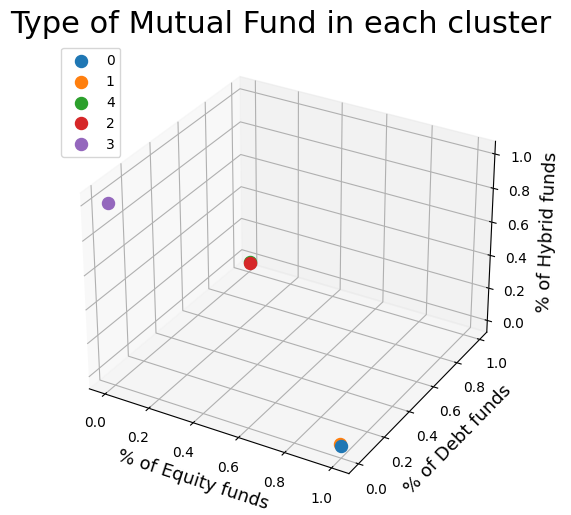

In [ ]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection='3d')

for i in raw_df['kmeans_1'].unique():
    xs = raw_df[raw_df['kmeans_1']==i]['Category_Equity'].mean()
    ys = raw_df[raw_df['kmeans_1']==i]['Category_Debt'].mean()
    zs = raw_df[raw_df['kmeans_1']==i]['Category_Hybrid'].mean()
    # print(xs,ys,zs)
    ax.scatter(xs, ys, zs, label=str(i),s=75)

    
ax.set_title('Type of Mutual Fund in each cluster ',loc='center', fontsize=22)
ax.set_xlabel('% of Equity funds', fontsize=13)
ax.set_ylabel('% of Debt funds', fontsize=13)
ax.set_zlabel('% of Hybrid funds', fontsize=13)
ax.legend(loc = 2)
plt.show()

In [ ]:
raw_df.groupby(['kmeans_1'])[['Category_Equity',
                              'Category_Debt',
                              'Category_Hybrid'
                             ]].agg([np.mean])

,Category_Equity,Category_Debt,Category_Hybrid
,mean,mean,mean
kmeans_1,,,
0,1.000000,0.000000,0.000000
1,0.992727,0.000000,0.007273
2,0.016129,0.983871,0.000000
3,0.000000,0.000000,1.000000
4,0.008547,0.991453,0.000000


<ipython-input-35-cf4c52d0bbaf>:7: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


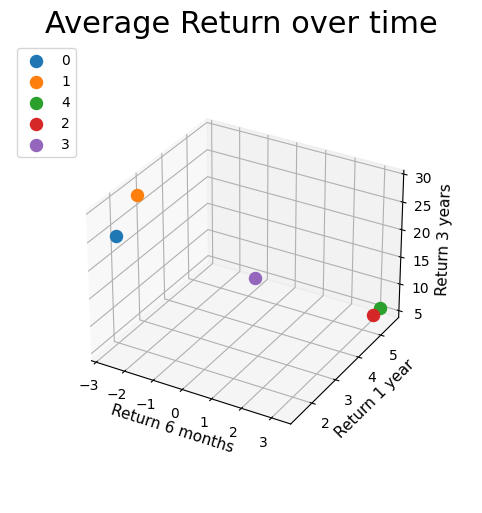

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection='3d')
ax.dist = 13

for i in raw_df['kmeans_1'].unique():
    xs =  np.average(raw_df[raw_df['kmeans_1']==i]['Return_6m'])
    ys = np.average(raw_df[raw_df['kmeans_1']==i]['Return_1yr'])
    zs = np.average(raw_df[raw_df['kmeans_1']==i]['Return_3yr'])
    ax.scatter(xs, ys, zs, label=str(i),s=75)

    
ax.set_title('Average Return over time',loc='center', fontsize=22)
ax.set_xlabel('Return 6 months', fontsize=11)
ax.set_ylabel('Return 1 year', fontsize=11)
ax.set_zlabel('Return 3 years', fontsize=11)
ax.legend(loc = 2)
plt.show()

<ipython-input-36-c99daa6224a3>:7: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


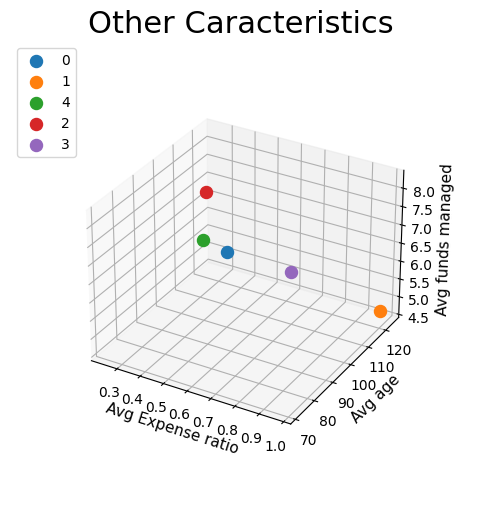

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection='3d')
ax.dist = 13

for i in raw_df['kmeans_1'].unique():
    xs = np.average(raw_df[raw_df['kmeans_1']==i]['Expense_ratio']) 
    ys = np.average(raw_df[raw_df['kmeans_1']==i]['age_in_months'])
    zs = np.average(raw_df[raw_df['kmeans_1']==i]['#_Funds_managed'])
    ax.scatter(xs, ys, zs, label=str(i),s=75)

    
ax.set_title('Other Caracteristics',loc='center', fontsize=22)
ax.set_xlabel('Avg Expense ratio', fontsize=11)
ax.set_ylabel('Avg age', fontsize=11)
ax.set_zlabel('Avg funds managed', fontsize=11)
ax.legend(loc = 2)
plt.show()

In [ ]:
raw_df.groupby(['kmeans_1'])[['Expense_ratio',
                              'age_in_months',
                              '#_Funds_managed'
                             ]].agg([np.average])

,Expense_ratio,age_in_months,#_Funds_managed
,average,average,average
kmeans_1,,,
0,0.737629,71.386598,8.221649
1,0.975018,123.836364,4.669091
2,0.241774,120.645161,6.822581
3,0.773168,100.099379,6.459627
4,0.401496,99.841880,6.683761


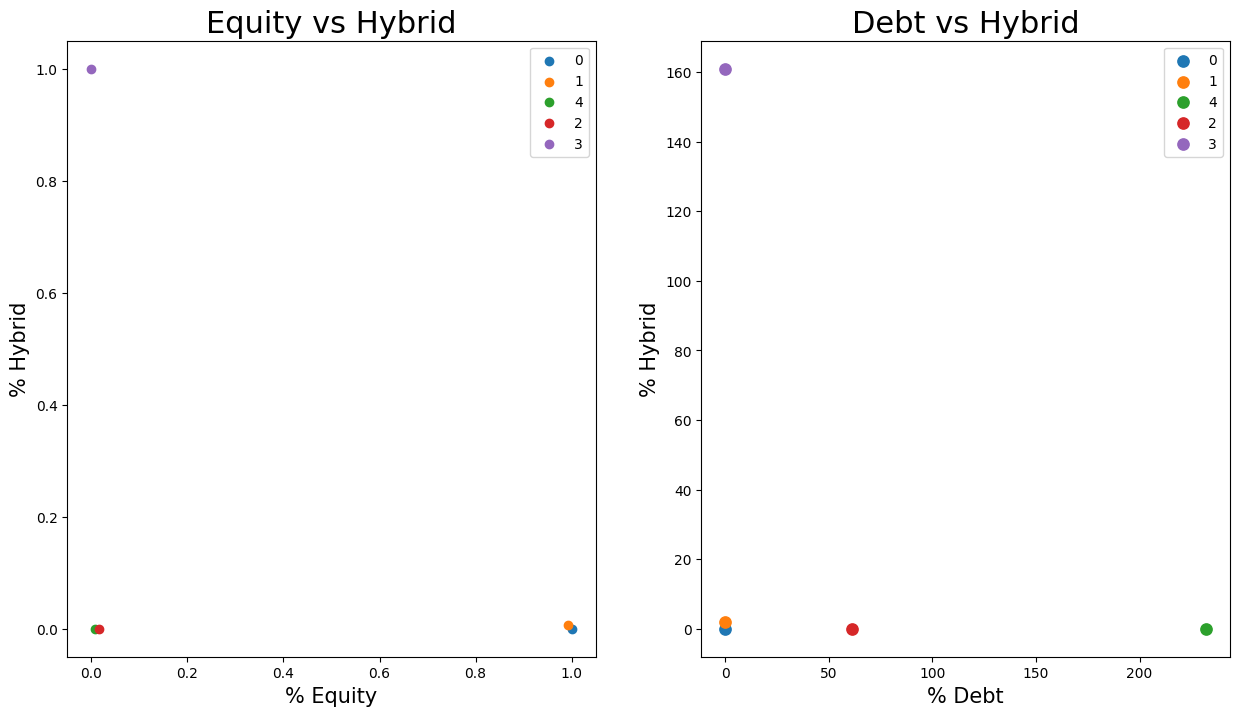

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,8),sharey=False)
ax = ax.ravel()
for i in raw_df['kmeans_1'].unique():
    ax[0].scatter(raw_df[raw_df['kmeans_1']==i]['Category_Equity'].mean()
                  ,raw_df[raw_df['kmeans_1']==i]['Category_Hybrid'].mean()
                  , label=str(i))
    ax[1].scatter(raw_df[raw_df['kmeans_1']==i]['Category_Debt'].sum()
                  ,raw_df[raw_df['kmeans_1']==i]['Category_Hybrid'].sum()
                  , label=str(i),s=66)
    
ax[0].set_title('Equity vs Hybrid', fontsize=22)
ax[0].set_xlabel('% Equity', fontsize=15)
ax[0].set_ylabel('% Hybrid', fontsize=15)
ax[0].legend()

ax[1].set_title('Debt vs Hybrid', fontsize=22)
ax[1].set_xlabel('% Debt', fontsize=15)
ax[1].set_ylabel('% Hybrid', fontsize=15)
ax[1].legend()

t-Distributed Stochastic Neighbor Embedding (t-SNE) Plot

In [ ]:
def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))
    
    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)]) #palette[colors.astype(np.int)]
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [ ]:
time_start = time.time()
fashion_tsne = TSNE(random_state=42).fit_transform(raw_df[features])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 5.0518670082092285 seconds


In [ ]:
raw_df['colors'] =  raw_df['kmeans_1'].map({0: 'k', 1: 'k',2:'k',3:'k',4:'k',5:'k'})

In [ ]:
num_classes = len(np.unique(raw_df['kmeans_1']))
palette = np.array(sns.color_palette("hls", num_classes))
palette

array([[0.86  , 0.3712, 0.34  ],
       [0.7248, 0.86  , 0.34  ],
       [0.34  , 0.86  , 0.5792],
       [0.34  , 0.5168, 0.86  ],
       [0.7872, 0.34  , 0.86  ]])

In [ ]:
# 0 = red = 219,94,87
# 1 = yellow 185,219,87
# 2 = Green 86,219 , 147
# 3 = blue 86,131,219
# 4 = pink 200, 87, 219

<ipython-input-39-101145111def>:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)]) #palette[colors.astype(np.int)]


(<Figure size 800x800 with 1 Axes>,
 <Axes: >,
 [Text(-10.032431, 8.270968, '0'),
  Text(5.303666, -3.1026363, '1'),
  Text(5.3021326, -3.1110775, '2'),
  Text(-0.13188173, 7.8969164, '3'),
  Text(0.9104532, 6.5293636, '4')])

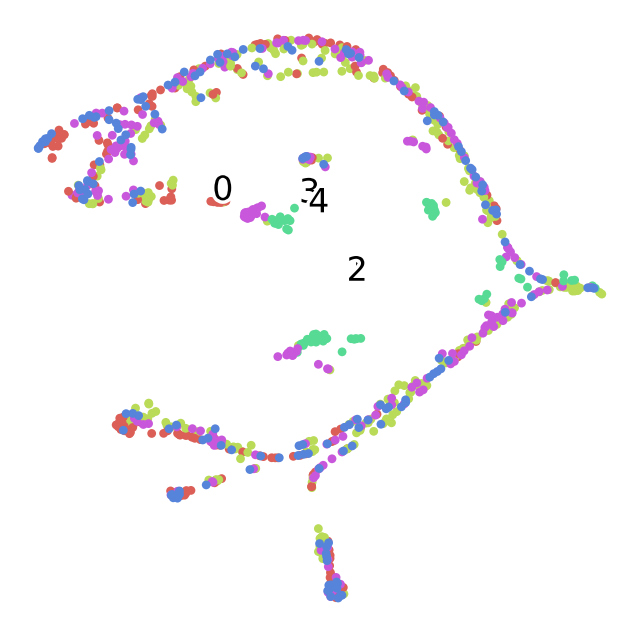

In [ ]:
fashion_scatter(fashion_tsne, raw_df['kmeans_1'])

<ipython-input-39-101145111def>:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)]) #palette[colors.astype(np.int)]


(<Figure size 800x800 with 1 Axes>,
 <Axes: >,
 [Text(-25.025597, 3.5000648, '0'),
  Text(-8.436059, 14.123182, '1'),
  Text(41.828007, 19.618343, '2'),
  Text(0.37561318, -35.330624, '3'),
  Text(30.51926, -4.8272967, '4')])

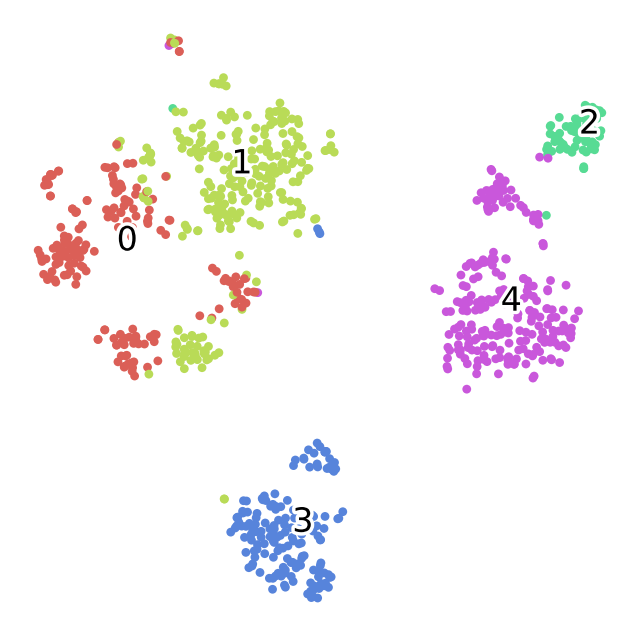

In [ ]:
## tsne
fashion_tsne = TSNE(random_state=42).fit_transform(X_sc[features])
fashion_scatter(fashion_tsne, raw_df['kmeans_1'])


Generating Plot examples for presentation

In [ ]:
raw_df.groupby(['kmeans_1'])\
                [["Category_Equity",'Category_Debt','Category_Hybrid', 'Return_3m',	'Return_6m',	'Return_1yr', 'NAV_latest'	,'NAV_52wk_high',	'NAV_52wk_low',
                  'age_in_months', '#_Funds_managed', 'Standard Deviation', 'Sharpe Ratio'
                 ]].agg([np.mean])

,Category_Equity,Category_Debt,Category_Hybrid,Return_3m,Return_6m,Return_1yr,NAV_latest,NAV_52wk_high,NAV_52wk_low,age_in_months,#_Funds_managed,Standard Deviation,Sharpe Ratio
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
kmeans_1,,,,,,,,,,,,,
0,1.000000,0.000000,0.000000,-3.579124,-2.435052,1.428454,64.530670,73.299072,55.704845,71.386598,8.221649,23.182732,0.635412
1,0.992727,0.000000,0.007273,-3.533309,-2.735309,2.544327,197.609800,217.445607,171.929247,123.836364,4.669091,22.733127,0.728364
2,0.016129,0.983871,0.000000,1.512419,3.120323,5.319677,3117.762823,3124.579452,2949.096113,120.645161,6.822581,1.532258,1.113548
3,0.000000,0.000000,1.000000,-0.927081,0.335404,3.674037,58.289497,60.682733,52.704565,100.099379,6.459627,10.064720,0.674534
4,0.008547,0.991453,0.000000,1.506325,3.200085,5.527479,273.112632,283.339709,255.151718,99.841880,6.683761,2.702906,0.738547


In [ ]:
raw_df.groupby(['kmeans_1'])\
                [['Return_3m',	'Return_6m',	'Return_1yr', 'NAV_latest'	,'NAV_52wk_high',	'NAV_52wk_low',
                  'age_in_months', '#_Funds_managed', 'Standard Deviation', 'Sharpe Ratio'
                 ]].agg([np.mean])

,Return_3m,Return_6m,Return_1yr,NAV_latest,NAV_52wk_high,NAV_52wk_low,age_in_months,#_Funds_managed,Standard Deviation,Sharpe Ratio
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
kmeans_1,,,,,,,,,,
0,-3.579124,-2.435052,1.428454,64.530670,73.299072,55.704845,71.386598,8.221649,23.182732,0.635412
1,-3.533309,-2.735309,2.544327,197.609800,217.445607,171.929247,123.836364,4.669091,22.733127,0.728364
2,1.512419,3.120323,5.319677,3117.762823,3124.579452,2949.096113,120.645161,6.822581,1.532258,1.113548
3,-0.927081,0.335404,3.674037,58.289497,60.682733,52.704565,100.099379,6.459627,10.064720,0.674534
4,1.506325,3.200085,5.527479,273.112632,283.339709,255.151718,99.841880,6.683761,2.702906,0.738547
